In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv(r"train_processed_data.csv")
test = pd.read_csv(r"test_processed_data.csv")

In [3]:
selected_columns = ['Status',
    'Departure IATA Code',
    'Arrival IATA Code',
    'Arrival ICAO Code',
    'Airline Name',
    'Airline IATA Code',
    'Airline ICAO Code',
    'Flight ICAO Number',
    'Flight Number',
    'Departure Scheduled Hour',
    'Departure Scheduled Day',
    'Departure Scheduled Year',
    'Departure Actual Runway Hour',
    'Departure Actual Runway Day',
    'Humidity (%)',
    'Delay'
]
train = train[selected_columns]
test = test[selected_columns]

In [4]:
train['Delay'] = train['Delay'].apply(lambda x : 0 if x < 0 else x)
test['Delay'] = test['Delay'].apply(lambda x : 0 if x < 0 else x)

In [5]:
train_cols = train.columns
test_cols = test.columns
for i in train_cols:
    if i not in test_cols:
        print(i)

In [6]:
# def remove_outliers_iqr(data, cols):
    
#     for col in cols:
#         # print(data[col])
#         # print(data[col].quantile(0.25))
#         Q1 = data[col].quantile(0.25)
#         Q3 = data[col].quantile(0.75)
#         IQR = Q3 - Q1
        
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
        
#         data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    
#     return data
# columns = ['Humidity (%)', 'Wind Speed (mph)', 'Pressure (in)']
# train = remove_outliers_iqr(train, columns)
# test = remove_outliers_iqr(test, columns)

# bin_train = remove_outliers_iqr(bin_train, columns)
# #test_binary = remove_outliers_iqr(test_binary, columns)

# train.drop(columns = ['Precipitation (in)'], inplace = True)
# test.drop(columns = ['Precipitation (in)'], inplace = True)

In [7]:
train.columns

Index(['Status', 'Departure IATA Code', 'Arrival IATA Code',
       'Arrival ICAO Code', 'Airline Name', 'Airline IATA Code',
       'Airline ICAO Code', 'Flight ICAO Number', 'Flight Number',
       'Departure Scheduled Hour', 'Departure Scheduled Day',
       'Departure Scheduled Year', 'Departure Actual Runway Hour',
       'Departure Actual Runway Day', 'Humidity (%)', 'Delay'],
      dtype='object')

#### Binary Classification

In [8]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score,  f1_score, precision_recall_curve, average_precision_score, auc, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, GridSearchCV

In [9]:
# Separate categorical and numerical columns
tr_cat_cols = train.select_dtypes(include=['object']).columns
tr_num_cols = train.select_dtypes(include=['int64', 'float64']).columns

te_cat_cols = test.select_dtypes(include=['object']).columns
te_num_cols = test.select_dtypes(include=['int64', 'float64']).columns

print('Train Categorical features: ', tr_cat_cols)
print('Test Categorical features: ', te_cat_cols)

print('Train Categorical features: ', tr_num_cols)
print('Test Categorical features: ', te_num_cols)

tr_num_cols = np.array(tr_num_cols)
tr_num_cols = tr_num_cols[tr_num_cols != 'Delay'].tolist()

te_num_cols = np.array(te_num_cols)
te_num_cols = te_num_cols[te_num_cols != 'Delay'].tolist()

# train.drop(columns = tr_cat_cols, inplace = True)
# test.drop(columns = tr_cat_cols, inplace = True)

Train Categorical features:  Index(['Status', 'Departure IATA Code', 'Arrival IATA Code',
       'Arrival ICAO Code', 'Airline Name', 'Airline IATA Code',
       'Airline ICAO Code', 'Flight ICAO Number', 'Departure Scheduled Day',
       'Departure Actual Runway Day'],
      dtype='object')
Test Categorical features:  Index(['Status', 'Departure IATA Code', 'Arrival IATA Code',
       'Arrival ICAO Code', 'Airline Name', 'Airline IATA Code',
       'Airline ICAO Code', 'Flight ICAO Number', 'Departure Scheduled Day',
       'Departure Actual Runway Day'],
      dtype='object')
Train Categorical features:  Index(['Flight Number', 'Departure Scheduled Hour', 'Departure Scheduled Year',
       'Departure Actual Runway Hour', 'Humidity (%)', 'Delay'],
      dtype='object')
Test Categorical features:  Index(['Flight Number', 'Departure Scheduled Hour', 'Departure Scheduled Year',
       'Departure Actual Runway Hour', 'Humidity (%)', 'Delay'],
      dtype='object')


In [10]:
label_encoders = {}

for col in tr_cat_cols:
    label_enc = LabelEncoder()
    train[col] = label_enc.fit_transform(train[col])  # Fit and transform on train
    test[col] = label_enc.fit_transform(test[col])  # Fit and transform on train
    label_encoders[col] = label_enc
# Standard scaling for numerical columns
scaler = StandardScaler()

train[tr_num_cols] = scaler.fit_transform(train[tr_num_cols])  # Fit and transform on train
test[te_num_cols] = scaler.fit_transform(test[te_num_cols])  # Fit and transform on train

#### Classification Using Decision Trees

In [11]:
def categorize_delay(delay, model):
    if model == "binary":
        if delay <= 0:
            return 0
        elif delay > 0:
            return 1
            
    if model == "multiclass":
        if delay <= 0:
            return 'No' 
        elif delay > 0 and delay <= 2700:
            return 'S' 
        elif delay > 2700 and delay <= 10500:
            return 'M'  
        elif delay > 10500:
            return 'L'  

In [12]:
X_train = train.iloc[:, :-1]
X_test = test.iloc[:, :-1]
Y_train = train['Delay'].apply(lambda x: categorize_delay(x, 'binary'))
Y_test = test['Delay'].apply(lambda x: categorize_delay(x, 'binary'))

In [13]:
tree = DecisionTreeClassifier( random_state=42, max_depth=6, min_samples_split=20,  min_samples_leaf=5, max_features='sqrt', criterion='entropy', splitter='best')
Y_fit = tree.fit(X_train, Y_train)

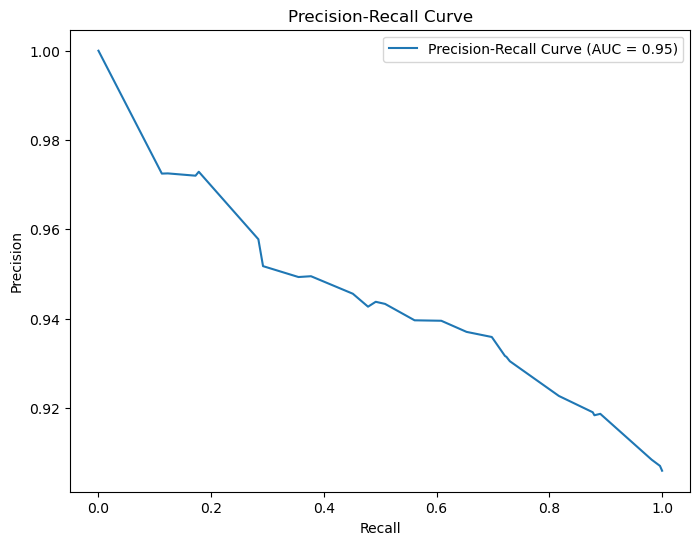

In [14]:
Y_scores = tree.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(Y_test, Y_scores)
auc_score = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [15]:
Y_pred = tree.predict(X_test)
Y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [16]:
print(" Decision Tree model accuracy", metrics.accuracy_score(Y_test, Y_pred) * 100)

 Decision Tree model accuracy 90.59020791415158


In [17]:
def encode(delay):
    if delay == 0:
        return 'on-time'
    elif delay > 0:
        return 'delayed'
    

In [18]:
print(len(Y_pred[0:12914]))

12914


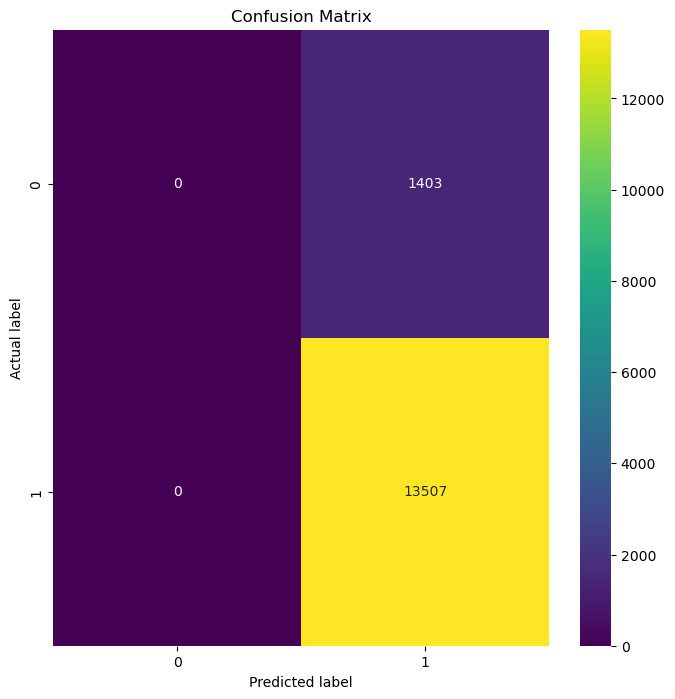

In [19]:
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [20]:
f1 = f1_score(Y_test, Y_pred)
print(" Decision Tree f1 score", f1)

 Decision Tree f1 score 0.9506281451243974


In [21]:
X_train = train.iloc[:, :-1]
Y_train = train['Delay'].apply(lambda x: categorize_delay(x, 'binary'))

kf = KFold(n_splits=5, random_state=None, shuffle=True)

# For storing MAE results
acc = []  # Store MAE for each fold

for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = Y_train.iloc[train_index], Y_train.iloc[val_index]

    tree = DecisionTreeClassifier( random_state=42, max_depth=6, min_samples_split=20,  min_samples_leaf=5, max_features='sqrt', criterion='entropy', splitter='best')
    
    # Train the model on the training fold
    tree.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation fold
    y_pred = tree.predict(X_val_fold)
    
    a = metrics.accuracy_score(y_val_fold, y_pred) * 100
    acc.append(a)
    
    print(f"Fold {fold+1}: Accuracy = {a:.4f}")

print(f"Average accuracy across folds: {np.mean(acc):.4f}")

Fold 1: Accuracy = 91.4881
Fold 2: Accuracy = 91.1682
Fold 3: Accuracy = 90.7795
Fold 4: Accuracy = 90.8377
Fold 5: Accuracy = 91.0704
Average accuracy across folds: 91.0688


In [22]:

param_grid = {
    'max_depth': [3, 4, 6, 7, 8],
    'min_samples_split': [10, 20, 30, 40, 50, 60],
    'min_samples_leaf': [10, 15, 20, 25, 30, 35, 40],
    'criterion': ['entropy', 'gini']
}
dtree = DecisionTreeClassifier(random_state=42)


grid_search = GridSearchCV(
    estimator=dtree,
    param_grid=param_grid,
    cv=4,               
    verbose=2,         
    scoring='accuracy' 
)

# Fit the model 
grid_search.fit(X_train, Y_train)

# Get best estimator
best_dtree = grid_search.best_estimator_
y_pred = best_dtree.predict(X_test)
acc = accuracy_score(Y_test, y_pred) * 100
best_params = grid_search.best_params_

# Print results
print(f"Best parameters: {best_params}")
print(f"Test accuracy: {acc:.2f}%")


Fitting 4 folds for each of 420 candidates, totalling 1680 fits
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=10, min_samples_split=20; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=10, min_samples_split=20; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=10, min_samples_split=20; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=10, min_samples_split=20; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=10, min_samples_split=30; total time=   0.0s
[CV] END 

##### train with tuned parameters

In [23]:
#Best parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 10}
tree = DecisionTreeClassifier( random_state=42, max_depth=4, min_samples_split=10,  min_samples_leaf=10, max_features='sqrt', criterion='entropy', splitter='best')
Y_fit = tree.fit(X_train, Y_train)


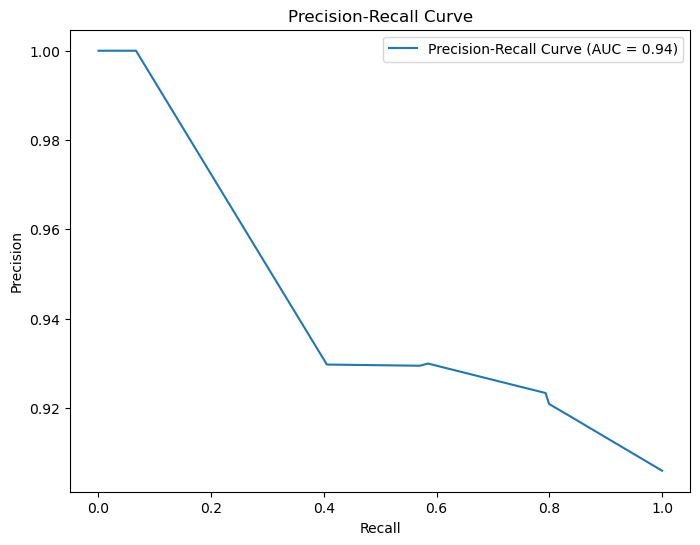

In [24]:
Y_scores = tree.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(Y_test, Y_scores)
auc_score = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


In [25]:
Y_pred = tree.predict(X_test)
print("Decision Tree model accuracy after tuning: ", metrics.accuracy_score(Y_test, Y_pred) * 100)

Decision Tree model accuracy after tuning:  90.59020791415158


In [26]:
f1 = f1_score(Y_test, Y_pred)
print(" Decision Tree f1 score", f1)

 Decision Tree f1 score 0.9506281451243974


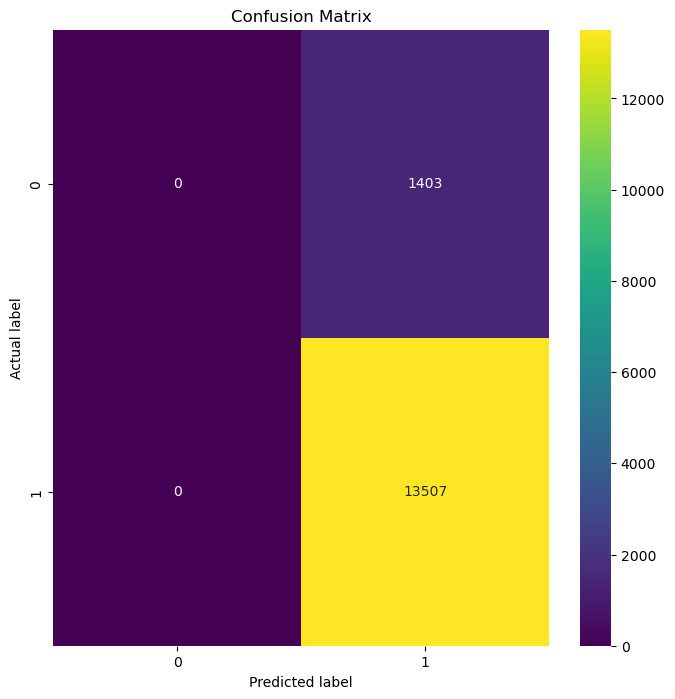

In [27]:
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [28]:
np.unique(Y_pred)

array([1], dtype=int64)

In [29]:
solution = pd.DataFrame({
    'ID': list(range(1, len(Y_pred[0:12914]) + 1)),
    'Delay': Y_pred[0:12914]
})

solution['Delay'] = solution['Delay'].apply(lambda x: encode(x))

solution.to_csv('predictions_binary.csv', index=False)
print(len(solution['Delay']))

12914


#### Multiclass 

In [30]:
X_train = train.iloc[:, :-1]
X_test = test.iloc[:, :-1]
Y_train = train['Delay'].apply(lambda x: categorize_delay(x, 'multiclass'))
Y_test = test['Delay'].apply(lambda x: categorize_delay(x, 'multiclass'))


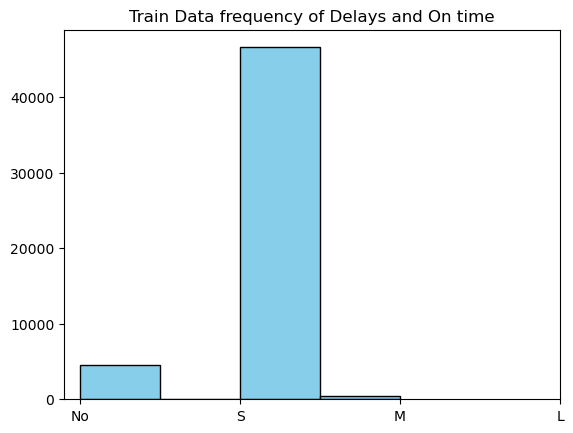

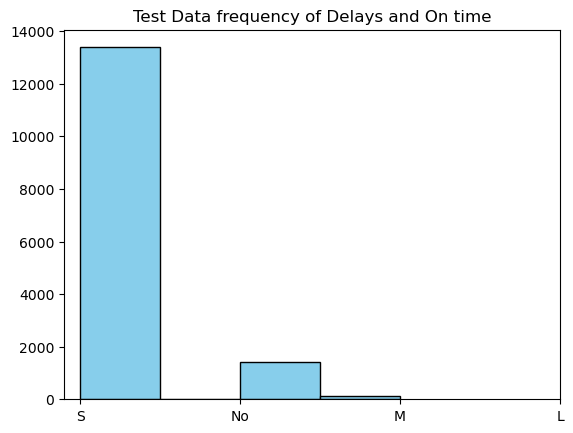

In [31]:
plot_train = train['Delay'].apply(lambda x: categorize_delay(x, 'multiclass'))
plot_test = test['Delay'].apply(lambda x: categorize_delay(x, 'multiclass'))

plt.hist(plot_train, bins=4, color='skyblue', edgecolor='black')
plt.xticks(['No', 'S', 'M', 'L'], ['No', 'S', 'M', 'L'])
plt.title('Train Data frequency of Delays and On time')
plt.show()

plt.hist(plot_test, bins=4, color='skyblue', edgecolor='black')
plt.xticks(['No', 'S', 'M', 'L'], ['No', 'S', 'M', 'L'])
plt.title('Test Data frequency of Delays and On time')
plt.show()

from sklearn.ensemble import RandomForestClassifier

In [32]:
classifier = RandomForestClassifier(n_estimators=1500, random_state=42)
classifier.fit(X_train, Y_train)


RandomForestClassifier(n_estimators=1500, random_state=42)

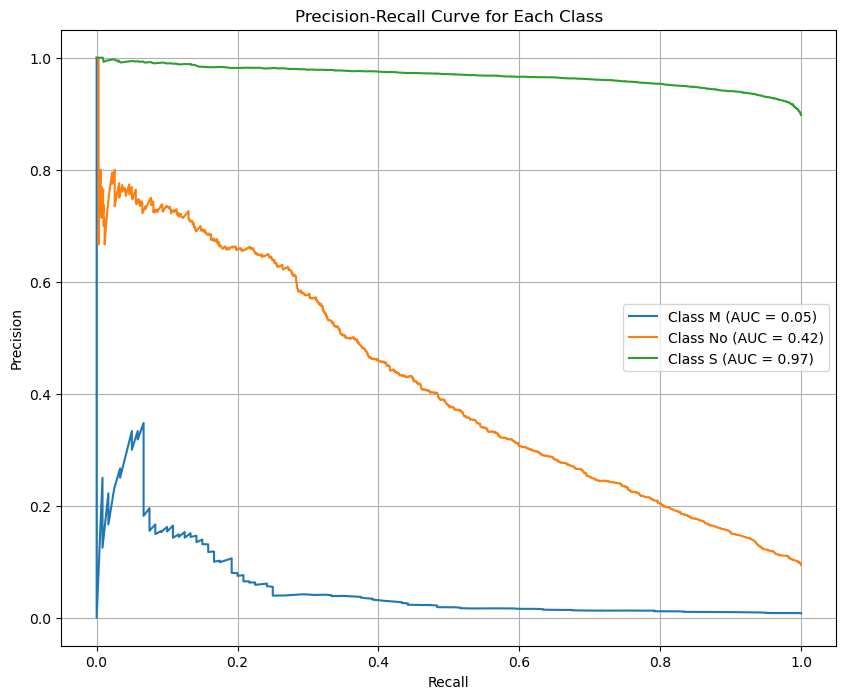

In [33]:
from sklearn.preprocessing import label_binarize
classes = np.unique(Y_test)
bin_Y_test = label_binarize(Y_test, classes=classes)

plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
 
    Y_scores = classifier.predict_proba(X_test)[:, i] 
    Y_true = bin_Y_test[:, i]
    
   
    precision, recall, thresholds = precision_recall_curve(Y_true, Y_scores)
    auc_score = auc(recall, precision)
    plt.plot(recall, precision, label=f"Class {class_label} (AUC = {auc_score:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Class")
plt.legend()
plt.grid()
plt.show()

In [34]:
Y_pred = classifier.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)

In [35]:
print(" Random Forest model accuracy", metrics.accuracy_score(Y_test, Y_pred) * 100)

 Random Forest model accuracy 90.24815560026828


In [36]:
f1 = f1_score(Y_test, Y_pred, average='weighted')
print(" Decision Tree f1 score", f1)

 Decision Tree f1 score 0.8642861416358765


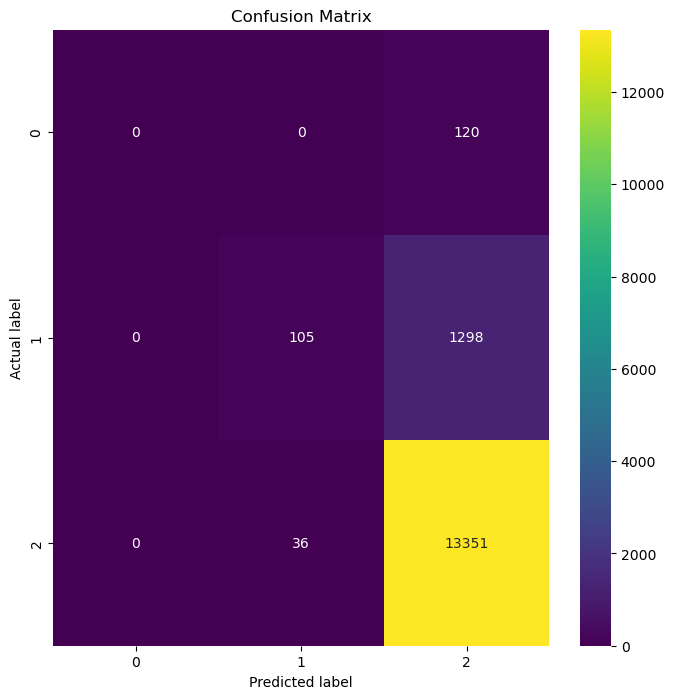

In [37]:
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [38]:
def encode2(delay):
    if delay == 'No':
        return 'No Delay'
        
    elif delay == 'S':
        return 'Short Delay'
        
    elif delay == 'M':
        return 'Moderate Delay'
        
    elif delay == 'L':
        return 'Long Delay'


In [ ]:
X_train = train.iloc[:, :-1]
Y_train = train['Delay'].apply(lambda x: categorize_delay(x, 'multiclass'))

kf = KFold(n_splits=5, random_state=None, shuffle=True)

acc = [] 

for fold, (train_index, val_index) in enumerate(kf.split(X_train)):

    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = Y_train.iloc[train_index], Y_train.iloc[val_index]

    classifier = RandomForestClassifier(n_estimators=1500, random_state=42)
    
    classifier.fit(X_train_fold, y_train_fold)
    
    y_pred = tree.predict(X_val_fold)
    
    a = metrics.accuracy_score(y_val_fold, y_pred) * 100
    acc.append(a)
    
    print(f"Fold {fold+1}: accuracy = {a:.4f}")

print(f"Average accuracy across folds: {np.mean(acc):.4f}")

Fold 1: accuracy = 0.0000
Fold 2: accuracy = 0.0000
Fold 3: accuracy = 0.0000


In [ ]:
X_train = train.iloc[:, :-1]
X_test = test.iloc[:, :-1]
Y_train = train['Delay'].apply(lambda x: categorize_delay(x, 'multiclass'))
Y_test = test['Delay'].apply(lambda x: categorize_delay(x, 'multiclass'))

IndexingError: Too many indexers

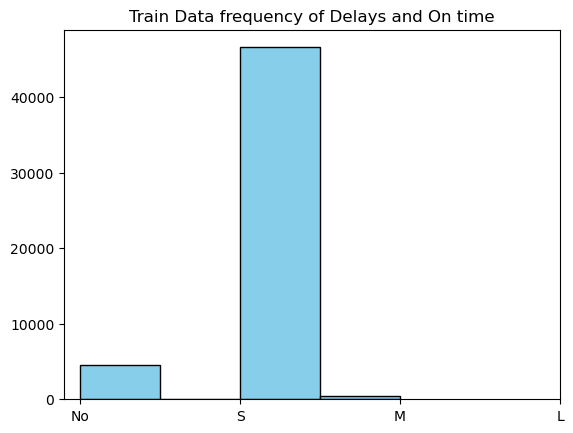

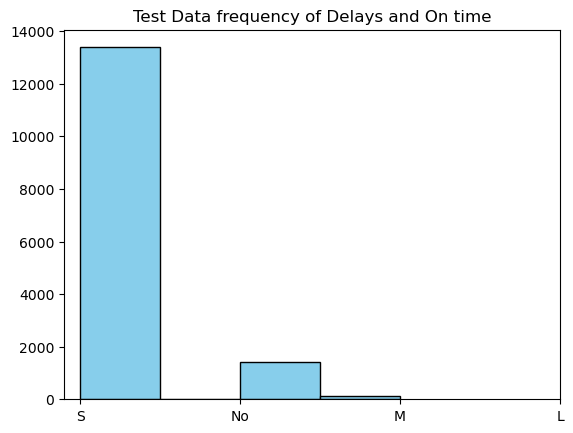

In [ ]:
plot_train = train['Delay'].apply(lambda x: categorize_delay(x, 'multiclass'))
plot_test = test['Delay'].apply(lambda x: categorize_delay(x, 'multiclass'))

plt.hist(plot_train, bins=4, color='skyblue', edgecolor='black')
plt.xticks(['No', 'S', 'M', 'L'], ['No', 'S', 'M', 'L'])
plt.title('Train Data frequency of Delays and On time')
plt.show()

plt.hist(plot_test, bins=4, color='skyblue', edgecolor='black')
plt.xticks(['No', 'S', 'M', 'L'], ['No', 'S', 'M', 'L'])
plt.title('Test Data frequency of Delays and On time')
plt.show()

from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.utils import resample
train = train['Delay'].apply(lambda x: categorize_delay(x, 'multiclass'))
df_major_0 = train[train['Delay'] == 'No']
df_major_1 = train[train['Delay'] == 'S']
df_major_2 = train[train['Delay']== 'M']
df_major_3 = train[train['Delay'] == 'L']

max_samples = train['Delay'].value_counts().max()

# Upsampling the minority classes in training set
df_minor_sample_0 = resample(df_major_0, replace=True, n_samples=max_samples, random_state=42)
df_minor_sample_1 = resample(df_major_1, replace=True, n_samples=max_samples, random_state=42)
df_minor_sample_2 = resample(df_major_2, replace=True, n_samples=max_samples, random_state=42)
df_minor_sample_3 = resample(df_major_3, replace=True, n_samples=max_samples, random_state=42)

# Combine the upsampled training classes
train_sampled = pd.concat([df_minor_sample_0, df_minor_sample_1, df_minor_sample_2, df_minor_sample_3])

# Get the upsampled X_train and y_train
X_train_upsampled = train_sampled.drop(columns=['Delay'])
y_train_upsampled = train_sampled['Delay']

# Display the class distribution in the upsampled training set
print("Class distribution in the upsampled training set:")
print(train_sampled['Delay'].value_counts())

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq\\backend\\cython\\checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt: 


KeyError: 'Delay'

In [ ]:
# Define the parameter grid (fixed missing commas)
param_grid = {
    'max_depth': [3, 4, 6, 7, 8],
    'min_samples_split': [10, 20, 30, 40, 50, 60],
    'min_samples_leaf': [10, 15, 20, 25, 30, 35, 40],
    'splitter': ['best', 'random'],
    'criterion': ['entropy', 'gini']
}


dtree = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=dtree,
    param_grid=param_grid,
    cv=4,              
    verbose=2,      
    scoring='accuracy'  
)

# Fit the model to the training data
grid_search.fit(X_train, Y_train)

# Get the best estimator and evaluate on the test set
best_dtree = grid_search.best_estimator_
y_pred = best_dtree.predict(X_test)
acc = accuracy_score(Y_test, y_pred) * 100
best_params = grid_search.best_params_

# Print results
print(f"Best parameters: {best_params}")
print(f"Test accuracy: {acc:.2f}%")


Fitting 4 folds for each of 840 candidates, totalling 3360 fits
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=10, min_samples_split=10, splitter=best; total time=   0.1s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=10, min_samples_split=10, splitter=best; total time=   0.1s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=10, min_samples_split=10, splitter=best; total time=   0.1s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=10, min_samples_split=10, splitter=best; total time=   0.1s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=10, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=10, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=10, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=10, min_samples_split=10, splitter=random; tot

In [ ]:
classifier = RandomForestClassifier(n_estimators=1500, random_state=42)
classifier.fit(X_train, Y_train)


RandomForestClassifier(n_estimators=1500, random_state=42)

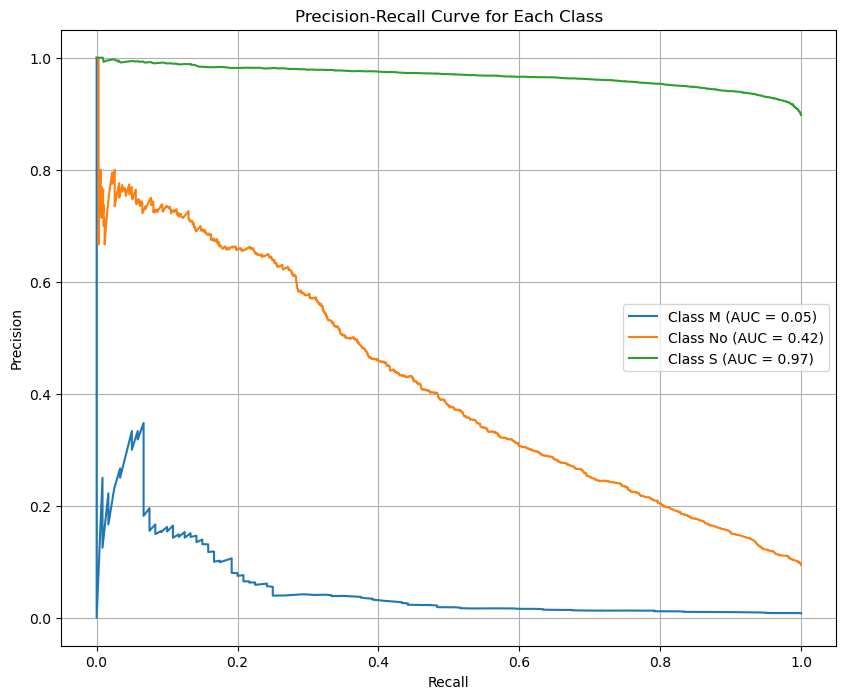

In [ ]:
classes = np.unique(Y_test)
bin_Y_test = label_binarize(Y_test, classes=classes)

plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
 
    Y_scores = classifier.predict_proba(X_test)[:, i] 
    Y_true = bin_Y_test[:, i]
    
   
    precision, recall, thresholds = precision_recall_curve(Y_true, Y_scores)
    auc_score = auc(recall, precision)
    plt.plot(recall, precision, label=f"Class {class_label} (AUC = {auc_score:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Class")
plt.legend()
plt.grid()
plt.show()

In [ ]:
Y_pred = classifier.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)

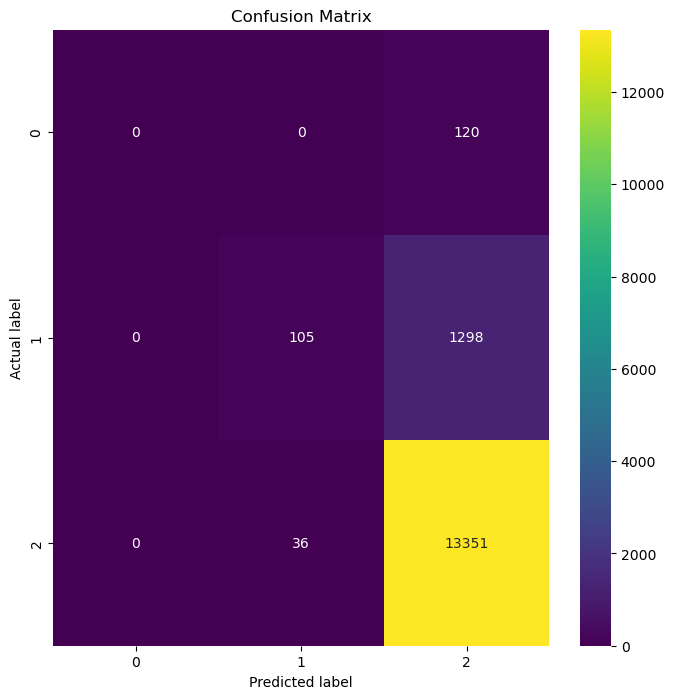

In [ ]:
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
solution = pd.DataFrame({
    'ID': list(range(1, len(Y_pred[0:12914]) + 1)),
    'Delay': Y_pred[0:12914]
})

solution.to_csv('predictions_multiclass.csv', index=False)

### Regression Model

In [ ]:
X_train = train.iloc[:, :-1]
X_test = test.iloc[:, :-1]

Y_train = train['Delay']
Y_test = test['Delay']

In [ ]:

regressor = LinearRegression()

regressor.fit(X_train, Y_train)

LinearRegression()

In [ ]:
Y_scores = regressor.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(Y_test, Y_scores)
auc_score = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

AttributeError: 'LinearRegression' object has no attribute 'predict_proba'

In [ ]:
# Checking the regression coefficients of the fitted model
print('The regression coefficients are:', regressor.coef_)

In [ ]:
# Checking the intercept
print('The intercept', regressor.intercept_)

In [ ]:
Y_pred = regressor.predict(X_test)
print("Predicted Delay:\n ", pd.DataFrame(data = {"Actual Delay": Y_test,"Predicted Delay":Y_pred}))

In [ ]:
solution = pd.DataFrame({
    'ID': list(range(1, len(Y_pred[0:12914]) + 1)),
    'Delay': Y_pred[0:12914]
})

#solution['Delay'] = solution['Delay'].apply(lambda x: 0 if x < 0 else x)

solution.to_csv('predictions_regression.csv', index=False)

In [ ]:
from sklearn.metrics import mean_absolute_error
import math

In [ ]:
MAE = mean_absolute_error(Y_test, y_pred)
print ("Mean Squared Error: ", MAE)
RMSE = math.sqrt(MAE)

print ("Root Mean Squared Error: ", RMSE)

In [ ]:
X_train = train.iloc[:, :-1]
Y_train = train.iloc[:, -1]

kf = KFold(n_splits=5, random_state=None, shuffle=True)

# For storing MAE results
mae_list = []  # Store MAE for each fold

for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = Y_train.iloc[train_index], Y_train.iloc[val_index]
    
    # Train the model on the training fold
    regressor.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation fold
    y_pred = regressor.predict(X_val_fold)
    
    # Calculate MAE for the current fold
    mae = mean_absolute_error(y_val_fold, y_pred)
    mae_list.append(mae)
    
    # Print MAE for this fold
    print(f"Fold {fold+1}: MAE = {mae:.4f}")

# Print the average MAE across all folds
print(f"Average MAE across folds: {np.mean(mae_list):.4f}")

In [ ]:

# Define the parameter grid for LinearRegression
param_grid = {
    'fit_intercept': [True, False],  # Whether to include the intercept
    'positive': [True, False]       # Restrict coefficients to be non-negative
}

# Initialize a Linear Regression model
linear_reg = LinearRegression()

# Perform GridSearchCV with MAE as the scoring metric
grid_search = GridSearchCV(
    estimator=linear_reg,
    param_grid=param_grid,
    cv=5,               # 5-fold cross-validation
    n_jobs=-1,          # Use all available processors
    verbose=2,          # Show progress
    scoring='neg_mean_absolute_error'  # Use negative MAE as the evaluation metric
)

# Fit the model to the training data
grid_search.fit(X_train, Y_train)

# Get the best estimator and evaluate on the test set
best_linear_reg = grid_search.best_estimator_
y_pred = best_linear_reg.predict(X_test)
mae = mean_absolute_error(Y_test, y_pred)
best_params = grid_search.best_params_

# Print results
print(f"Best parameters: {best_params}")
print(f"Test MAE: {mae:.2f}")

In [ ]:
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()